#  AT82.05 Artificial Intelligence: Natural Language Understanding (NLU)

## A7: Distillation, Get Smaller, Get Faster

### Name: Arya Shah
### StudentID: st125462

-----------

In this assignment, I will will explore the comparison between Odd Layer and Even Layer Student Training Models and LoRA (Low-Rank Adaptation) on a distillation task using BERT from Huggingface

You can find the GitHub Repository for the assignment here:
- https://github.com/aryashah2k/NLP-NLU (Complete Web App)
- https://github.com/aryashah2k/NLP-NLU/tree/main/notebooks (Assignment Notebooks)
- https://github.com/aryashah2k/NLP-NLU/tree/main/reports (Assignment Reports)

# Task 1. Hate Speech/Toxic Comment Dataset ✅

Find and load a dataset that includes toxic comments or hate speech. This dataset will be used for training and evaluating the models. (1 point) ✅

I made use of the following dataset and below is the proper credits and attribution of the dataset used:

## Dataset Description

The Civil Comments dataset is a collection of comments from the Civil Comments platform, which was a commenting plugin for independent news sites. It contains approximately 2 million public comments with toxicity and other attributes annotated by human moderators.

In our implementation, we use the Civil Comments dataset to train and evaluate models for toxic comment classification. We specifically create a balanced dataset with equal numbers of toxic and non-toxic comments to ensure fair model training and evaluation.

## Dataset Details

- **Name**: Civil Comments
- **Source**: Jigsaw (Conversation AI team at Google)
- **Size**: Approximately 2 million comments
- **Features**: Text comments with annotations for toxicity, severe toxicity, obscenity, threat, insult, identity attack, and more
- **Task**: Binary classification (toxic vs. non-toxic)
- **Access**: Available through the Hugging Face Datasets library

## Dataset Usage

In my implementation, I have:
1. Load the dataset using Hugging Face's `datasets` library
2. Create a balanced subset by sampling equal numbers of toxic and non-toxic comments
3. Define a comment as "toxic" if its toxicity score is greater than 0.5
4. Split the data into training, validation, and test sets (80%, 10%, 10%)
5. Tokenize the text using the BERT tokenizer for model input

## References

1. Jigsaw/Conversation AI. (2019). Civil Comments Dataset. [https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)
2. Borkan, D., Dixon, L., Sorensen, J., Thain, N., & Vasserman, L. (2019). Nuanced metrics for measuring unintended bias with real data for text classification. [arXiv:1903.04561](https://arxiv.org/abs/1903.04561)
3. Hugging Face. Civil Comments Dataset. [https://huggingface.co/datasets/civil_comments](https://huggingface.co/datasets/civil_comments)

Here's the `data_loader.py` script to setup the dataset:

In [ ]:
#!/usr/bin/env python
# coding: utf-8

"""
Data loader for the hate speech/toxic comment classification task.
This script loads the Jigsaw Toxic Comment Classification dataset and preprocesses it for training.
"""

import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def load_toxic_comments_dataset(model_name_or_path="bert-base-uncased", max_length=128, batch_size=32):
    """
    Load the Jigsaw Toxic Comment Classification dataset and preprocess it.
    
    Args:
        model_name_or_path (str): The model name or path for the tokenizer
        max_length (int): Maximum sequence length
        batch_size (int): Batch size for data loaders
    
    Returns:
        tokenizer: The tokenizer used for preprocessing
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        test_dataloader: DataLoader for test data
        num_labels: Number of labels in the dataset
    """
    print("Loading Jigsaw Toxic Comment Classification dataset...")
    
    # Load the Civil Comments dataset (contains toxic comments)
    dataset = load_dataset("civil_comments")
    
    # Extract the relevant columns (text and toxicity label)
    dataset = dataset.map(
        lambda example: {
            "text": example["text"], 
            "label": 1 if example["toxicity"] > 0.5 else 0
        }
    )
    
    # Create a balanced dataset (50% toxic, 50% non-toxic)
    toxic_comments = dataset["train"].filter(lambda example: example["label"] == 1)
    non_toxic_comments = dataset["train"].filter(lambda example: example["label"] == 0)
    
    # Sample to ensure balance
    max_samples = min(len(toxic_comments), len(non_toxic_comments), 25000)  # Limit to 25k per class for efficiency
    toxic_samples = toxic_comments.select(range(max_samples))
    non_toxic_samples = non_toxic_comments.select(range(max_samples))
    
    # Combine and shuffle
    from datasets import concatenate_datasets
    balanced_dataset = concatenate_datasets([toxic_samples, non_toxic_samples])
    balanced_dataset = balanced_dataset.shuffle(seed=SEED)
    
    # Split into train, validation, and test sets (80%, 10%, 10%)
    train_val_dataset, test_dataset = balanced_dataset.train_test_split(test_size=0.1, seed=SEED).values()
    train_dataset, val_dataset = train_val_dataset.train_test_split(test_size=0.11, seed=SEED).values()  # 0.11 of 90% is ~10% of total
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
    
    # Tokenize datasets
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
    
    print("Tokenizing datasets...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)
    
    # Format datasets for PyTorch
    # Remove all columns except those needed by the model
    columns_to_keep = ['input_ids', 'attention_mask', 'label']
    tokenized_train = tokenized_train.remove_columns([col for col in tokenized_train.column_names if col not in columns_to_keep])
    tokenized_val = tokenized_val.remove_columns([col for col in tokenized_val.column_names if col not in columns_to_keep])
    tokenized_test = tokenized_test.remove_columns([col for col in tokenized_test.column_names if col not in columns_to_keep])
    
    # Rename 'label' to 'labels' to match model expectations
    tokenized_train = tokenized_train.rename_column('label', 'labels')
    tokenized_val = tokenized_val.rename_column('label', 'labels')
    tokenized_test = tokenized_test.rename_column('label', 'labels')
    
    tokenized_train.set_format("torch")
    tokenized_val.set_format("torch")
    tokenized_test.set_format("torch")
    
    # Create data loaders
    from torch.utils.data import DataLoader
    from transformers import DataCollatorWithPadding
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    train_dataloader = DataLoader(
        tokenized_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        tokenized_val, batch_size=batch_size, collate_fn=data_collator
    )
    test_dataloader = DataLoader(
        tokenized_test, batch_size=batch_size, collate_fn=data_collator
    )
    
    # Number of labels (binary classification - toxic or not)
    num_labels = 2
    
    return tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, train_dataset, val_dataset, test_dataset

if __name__ == "__main__":
    # Test the function
    tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, _, _, _ = load_toxic_comments_dataset()
    
    print(f"Number of labels: {num_labels}")
    print(f"Number of training batches: {len(train_dataloader)}")
    print(f"Number of evaluation batches: {len(eval_dataloader)}")
    print(f"Number of test batches: {len(test_dataloader)}")
    
    # Check a batch
    for batch in train_dataloader:
        print(f"Input IDs shape: {batch['input_ids'].shape}")
        print(f"Attention mask shape: {batch['attention_mask'].shape}")
        print(f"Labels shape: {batch['labels'].shape}")
        break

# Task 2. Odd Layer vs Even Layer Training ✅

Based on the case-studies/distilBERT.ipynb, modify as follows:
1) Train the student model using the odd layers {1, 3, 5, 7, 9, 11} from the 12-layer teacher to the 6-layer student. (1 point) ✅
2) Train the student model using the even layers {2, 4, 6, 8, 10, 12} from the 12-layer teacher to the 6-layer student. (1 point) ✅

Below are the two scripts I wrote for this process:

# `distillation_odd_layers.py`

In [ ]:
#!/usr/bin/env python
# coding: utf-8

"""
Implement knowledge distillation from BERT model (12 layers) to a smaller model (6 layers)
using the odd-numbered layers {1, 3, 5, 7, 9, 11} from the teacher model.
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForSequenceClassification,
    BertConfig,
    get_scheduler,
    AutoTokenizer
)
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module
import evaluate
from data_loader import load_toxic_comments_dataset

# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    """
    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        """
        Args:
            output_student: Student model output (logits)
            output_teacher: Teacher model output (logits)
            temperature: Temperature for softening probability distributions
        
        Returns:
            KL divergence loss
        """
        T = temperature
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def distill_bert_weights_odd_layers(teacher, student):
    """
    Copy weights from teacher to student, selecting odd-numbered layers from the teacher.
    
    Args:
        teacher: Teacher model
        student: Student model
        
    Returns:
        Student model with initialized weights
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_odd_layers(teacher_part, student_part)
    # Else if the part is an encoder, copy odd-numbered layers from teacher to student
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        
        # Map odd-numbered layers (1-indexed) from teacher to student
        # In 0-indexed arrays, this means layers 0, 2, 4, 6, 8, 10
        odd_layer_indices = [0, 2, 4, 6, 8, 10]
        
        for i, teacher_idx in enumerate(odd_layer_indices):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[teacher_idx].state_dict())
            print(f"Copied teacher layer {teacher_idx} to student layer {i}")
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student

def train_and_evaluate_distillation(
    teacher_model_name="bert-base-uncased",
    num_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    temperature=2.0,
    batch_size=32,
    max_length=128,
    output_dir="odd_layer_model"
):
    """
    Train and evaluate a distilled model with odd-numbered layers.
    
    Args:
        teacher_model_name: Name of the teacher model
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer
        temperature: Temperature for knowledge distillation
        batch_size: Batch size for training
        max_length: Maximum sequence length
        output_dir: Directory to save model and results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and preprocess data
    tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, _, _, _ = load_toxic_comments_dataset(
        model_name_or_path=teacher_model_name,
        max_length=max_length,
        batch_size=batch_size
    )
    
    # Load teacher model
    teacher_model = AutoModelForSequenceClassification.from_pretrained(
        teacher_model_name,
        num_labels=num_labels
    )
    
    print(f"Teacher model loaded: {teacher_model_name}")
    print(f"Teacher model config: {teacher_model.config}")
    
    # Create student model configuration
    configuration = teacher_model.config.to_dict()
    # Half the number of hidden layers
    configuration['num_hidden_layers'] //= 2
    configuration = BertConfig.from_dict(configuration)
    
    # Create uninitialized student model
    student_model = type(teacher_model)(configuration)
    
    # Initialize student model with odd layers from teacher
    student_model = distill_bert_weights_odd_layers(teacher=teacher_model, student=student_model)
    
    # Print model sizes
    teacher_params = count_parameters(teacher_model)
    student_params = count_parameters(student_model)
    print(f'Teacher parameters: {teacher_params:,}')
    print(f'Student parameters: {student_params:,}')
    print(f'Parameter reduction: {(1 - student_params/teacher_params) * 100:.2f}%')
    
    # Move models to device
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    
    # Set up loss functions
    criterion_div = DistillKL()
    criterion_ce = nn.CrossEntropyLoss()
    criterion_cos = nn.CosineEmbeddingLoss()
    
    # Set up optimizer and learning rate scheduler
    optimizer = optim.AdamW(
        params=student_model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Calculate number of training steps
    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_epochs * num_update_steps_per_epoch
    
    # Create learning rate scheduler
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    # Set up metric for evaluation
    metric = evaluate.load("accuracy")
    
    # Training and evaluation
    progress_bar = tqdm(range(num_training_steps))
    
    # Lists to store losses and metrics
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    eval_accuracies = []
    
    best_eval_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training
        student_model.train()
        teacher_model.eval()
        
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Compute student output
            outputs = student_model(**batch)
            
            # Compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)
            
            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # Classification loss
            loss_cls = outputs.loss
            train_loss_cls += loss_cls.item()
            
            # Distillation loss (KL divergence)
            loss_div = criterion_div(outputs.logits, output_teacher.logits, temperature)
            train_loss_div += loss_div.item()
            
            # Cosine embedding loss
            loss_cos = criterion_cos(
                output_teacher.logits,
                outputs.logits,
                torch.ones(output_teacher.logits.size()[0]).to(device)
            )
            train_loss_cos += loss_cos.item()
            
            # Combined loss
            loss = (loss_cls + loss_div + loss_cos) / 3
            train_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        
        # Calculate average losses for epoch
        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_loss_cls = train_loss_cls / len(train_dataloader)
        avg_train_loss_div = train_loss_div / len(train_dataloader)
        avg_train_loss_cos = train_loss_cos / len(train_dataloader)
        
        # Store losses
        train_losses.append(avg_train_loss)
        train_losses_cls.append(avg_train_loss_cls)
        train_losses_div.append(avg_train_loss_div)
        train_losses_cos.append(avg_train_loss_cos)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train loss: {avg_train_loss:.4f}')
        print(f'  - Loss_cls: {avg_train_loss_cls:.4f}')
        print(f'  - Loss_div: {avg_train_loss_div:.4f}')
        print(f'  - Loss_cos: {avg_train_loss_cos:.4f}')
        
        # Evaluation
        student_model.eval()
        eval_loss = 0
        
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)
            
            loss_cls = outputs.loss
            eval_loss += loss_cls.item()
            
            # Get predictions
            predictions = outputs.logits.argmax(dim=-1)
            
            # Add batch to metric
            metric.add_batch(
                predictions=predictions,
                references=batch["labels"]
            )
        
        # Calculate average evaluation loss and accuracy
        avg_eval_loss = eval_loss / len(eval_dataloader)
        eval_losses.append(avg_eval_loss)
        
        eval_metric = metric.compute()
        eval_accuracy = eval_metric['accuracy']
        eval_accuracies.append(eval_accuracy)
        
        print(f'  Eval loss: {avg_eval_loss:.4f}')
        print(f'  Eval accuracy: {eval_accuracy:.4f}')
        
        # Save the best model
        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            student_model.save_pretrained(os.path.join(output_dir, "best_model"))
            tokenizer.save_pretrained(os.path.join(output_dir, "best_model"))
            print(f'  New best model saved! Accuracy: {best_eval_accuracy:.4f}')
    
    # Final test evaluation
    student_model.eval()
    test_loss = 0
    metric = evaluate.load("accuracy")
    
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = student_model(**batch)
        
        loss = outputs.loss
        test_loss += loss.item()
        
        # Get predictions
        predictions = outputs.logits.argmax(dim=-1)
        
        # Add batch to metric
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"]
        )
    
    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / len(test_dataloader)
    test_metric = metric.compute()
    test_accuracy = test_metric['accuracy']
    
    print(f'Test Results:')
    print(f'  Test loss: {avg_test_loss:.4f}')
    print(f'  Test accuracy: {test_accuracy:.4f}')
    
    # Save test results
    test_results = {
        'test_loss': avg_test_loss,
        'test_accuracy': test_accuracy,
        'teacher_params': teacher_params,
        'student_params': student_params,
        'parameter_reduction': (1 - student_params/teacher_params) * 100
    }
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'train_losses_cls': train_losses_cls,
        'train_losses_div': train_losses_div,
        'train_losses_cos': train_losses_cos,
        'eval_losses': eval_losses,
        'eval_accuracies': eval_accuracies,
    }
    
    # Plot and save training curves
    epochs_list = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_list, train_losses, label='Total Train Loss')
    plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
    plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    plt.plot(epochs_list, eval_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs_list, eval_accuracies, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'))
    
    # Save final model
    student_model.save_pretrained(os.path.join(output_dir, "final_model"))
    tokenizer.save_pretrained(os.path.join(output_dir, "final_model"))
    
    # Save results as text file
    with open(os.path.join(output_dir, 'results.txt'), 'w') as f:
        f.write('Test Results:\n')
        f.write(f'  Test loss: {avg_test_loss:.4f}\n')
        f.write(f'  Test accuracy: {test_accuracy:.4f}\n\n')
        f.write(f'Model Information:\n')
        f.write(f'  Teacher parameters: {teacher_params:,}\n')
        f.write(f'  Student parameters: {student_params:,}\n')
        f.write(f'  Parameter reduction: {(1 - student_params/teacher_params) * 100:.2f}%\n')
    
    return student_model, test_results, history

if __name__ == "__main__":
    # Train and evaluate the distilled model with odd layers
    student_model, test_results, history = train_and_evaluate_distillation(
        teacher_model_name="bert-base-uncased",
        num_epochs=5,
        learning_rate=5e-5,
        weight_decay=0.01,
        temperature=2.0,
        batch_size=32,
        max_length=128,
        output_dir="odd_layer_model"
    )
    
    print("Distillation with odd layers completed successfully!")
    print(f"Test accuracy: {test_results['test_accuracy']:.4f}")


``` bash
(base) jupyter-st125462@puffer:~/NLP/A7$ python distillation_odd_layers.py
Using device: cuda
Using device: cuda
Loading Jigsaw Toxic Comment Classification dataset...
Train dataset size: 40050
Validation dataset size: 4950
Test dataset size: 5000
Tokenizing datasets...
Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:01<00:00, 4518.57 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Teacher model loaded: bert-base-uncased
Teacher model config: BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Copied teacher layer 0 to student layer 0
Copied teacher layer 2 to student layer 1
Copied teacher layer 4 to student layer 2
Copied teacher layer 6 to student layer 3
Copied teacher layer 8 to student layer 4
Copied teacher layer 10 to student layer 5
Teacher parameters: 109,483,778
Student parameters: 66,956,546
Parameter reduction: 38.84%
 20%|███████████████████████                                                                                            | 1252/6260 [04:09<15:57,  5.23it/s]Epoch 1/5:
  Train loss: 0.1895
  - Loss_cls: 0.4451
  - Loss_div: 0.0926
  - Loss_cos: 0.0308
  Eval loss: 0.4078
  Eval accuracy: 0.8992
  New best model saved! Accuracy: 0.8992
 40%|██████████████████████████████████████████████                                                                     | 2504/6260 [08:35<12:05,  5.18it/s]Epoch 2/5:
  Train loss: 0.1735
  - Loss_cls: 0.3784
  - Loss_div: 0.1149
  - Loss_cos: 0.0270
  Eval loss: 0.4065
  Eval accuracy: 0.9162
  New best model saved! Accuracy: 0.9162
 60%|█████████████████████████████████████████████████████████████████████                                              | 3756/6260 [13:04<08:02,  5.19it/s]Epoch 3/5:
  Train loss: 0.1665
  - Loss_cls: 0.3489
  - Loss_div: 0.1243
  - Loss_cos: 0.0263
  Eval loss: 0.3774
  Eval accuracy: 0.9168
  New best model saved! Accuracy: 0.9168
 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 5008/6260 [17:29<03:59,  5.24it/s]Epoch 4/5:
  Train loss: 0.1622
  - Loss_cls: 0.3306
  - Loss_div: 0.1301
  - Loss_cos: 0.0260
  Eval loss: 0.3853
  Eval accuracy: 0.9198
  New best model saved! Accuracy: 0.9198
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6260/6260 [21:55<00:00,  5.20it/s]Epoch 5/5:
  Train loss: 0.1603
  - Loss_cls: 0.3223
  - Loss_div: 0.1328
  - Loss_cos: 0.0257
  Eval loss: 0.3841
  Eval accuracy: 0.9190
Test Results:
  Test loss: 0.3852
  Test accuracy: 0.9166
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6260/6260 [22:12<00:00,  4.70it/s]
Distillation with odd layers completed successfully!
Test accuracy: 0.9166
```

### Results:

```text
Test Results:
  Test loss: 0.3852
  Test accuracy: 0.9166

Model Information:
  Teacher parameters: 109,483,778
  Student parameters: 66,956,546
  Parameter reduction: 38.84%
```

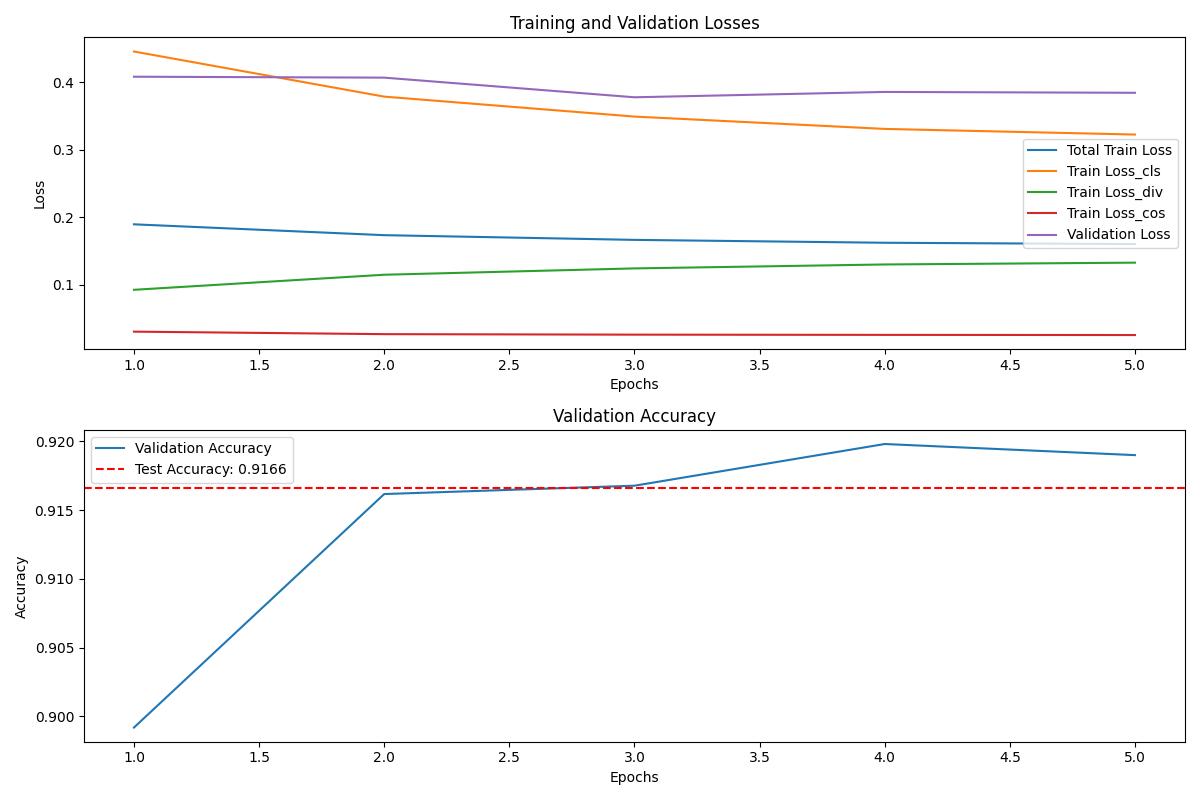

# `distillation_even_layers.py`

In [ ]:
#!/usr/bin/env python
# coding: utf-8

"""
Implement knowledge distillation from BERT model (12 layers) to a smaller model (6 layers)
using the even-numbered layers {2, 4, 6, 8, 10, 12} from the teacher model.
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForSequenceClassification,
    BertConfig,
    get_scheduler,
    AutoTokenizer
)
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module
import evaluate
from data_loader import load_toxic_comments_dataset

# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    """
    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        """
        Args:
            output_student: Student model output (logits)
            output_teacher: Teacher model output (logits)
            temperature: Temperature for softening probability distributions
        
        Returns:
            KL divergence loss
        """
        T = temperature
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def distill_bert_weights_even_layers(teacher, student):
    """
    Copy weights from teacher to student, selecting even-numbered layers from the teacher.
    
    Args:
        teacher: Teacher model
        student: Student model
        
    Returns:
        Student model with initialized weights
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_even_layers(teacher_part, student_part)
    # Else if the part is an encoder, copy even-numbered layers from teacher to student
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        
        # Map even-numbered layers (1-indexed) from teacher to student
        # In 0-indexed arrays, this means layers 1, 3, 5, 7, 9, 11
        even_layer_indices = [1, 3, 5, 7, 9, 11]
        
        for i, teacher_idx in enumerate(even_layer_indices):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[teacher_idx].state_dict())
            print(f"Copied teacher layer {teacher_idx} to student layer {i}")
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return student

def train_and_evaluate_distillation(
    teacher_model_name="bert-base-uncased",
    num_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    temperature=2.0,
    batch_size=32,
    max_length=128,
    output_dir="even_layer_model"
):
    """
    Train and evaluate a distilled model with even-numbered layers.
    
    Args:
        teacher_model_name: Name of the teacher model
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer
        temperature: Temperature for knowledge distillation
        batch_size: Batch size for training
        max_length: Maximum sequence length
        output_dir: Directory to save model and results
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and preprocess data
    tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, _, _, _ = load_toxic_comments_dataset(
        model_name_or_path=teacher_model_name,
        max_length=max_length,
        batch_size=batch_size
    )
    
    # Load teacher model
    teacher_model = AutoModelForSequenceClassification.from_pretrained(
        teacher_model_name,
        num_labels=num_labels
    )
    
    print(f"Teacher model loaded: {teacher_model_name}")
    print(f"Teacher model config: {teacher_model.config}")
    
    # Create student model configuration
    configuration = teacher_model.config.to_dict()
    # Half the number of hidden layers
    configuration['num_hidden_layers'] //= 2
    configuration = BertConfig.from_dict(configuration)
    
    # Create uninitialized student model
    student_model = type(teacher_model)(configuration)
    
    # Initialize student model with even layers from teacher
    student_model = distill_bert_weights_even_layers(teacher=teacher_model, student=student_model)
    
    # Print model sizes
    teacher_params = count_parameters(teacher_model)
    student_params = count_parameters(student_model)
    print(f'Teacher parameters: {teacher_params:,}')
    print(f'Student parameters: {student_params:,}')
    print(f'Parameter reduction: {(1 - student_params/teacher_params) * 100:.2f}%')
    
    # Move models to device
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    
    # Set up loss functions
    criterion_div = DistillKL()
    criterion_ce = nn.CrossEntropyLoss()
    criterion_cos = nn.CosineEmbeddingLoss()
    
    # Set up optimizer and learning rate scheduler
    optimizer = optim.AdamW(
        params=student_model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Calculate number of training steps
    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_epochs * num_update_steps_per_epoch
    
    # Create learning rate scheduler
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    # Set up metric for evaluation
    metric = evaluate.load("accuracy")
    
    # Training and evaluation
    progress_bar = tqdm(range(num_training_steps))
    
    # Lists to store losses and metrics
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    eval_accuracies = []
    
    best_eval_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training
        student_model.train()
        teacher_model.eval()
        
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Compute student output
            outputs = student_model(**batch)
            
            # Compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)
            
            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # Classification loss
            loss_cls = outputs.loss
            train_loss_cls += loss_cls.item()
            
            # Distillation loss (KL divergence)
            loss_div = criterion_div(outputs.logits, output_teacher.logits, temperature)
            train_loss_div += loss_div.item()
            
            # Cosine embedding loss
            loss_cos = criterion_cos(
                output_teacher.logits,
                outputs.logits,
                torch.ones(output_teacher.logits.size()[0]).to(device)
            )
            train_loss_cos += loss_cos.item()
            
            # Combined loss
            loss = (loss_cls + loss_div + loss_cos) / 3
            train_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        
        # Calculate average losses for epoch
        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_loss_cls = train_loss_cls / len(train_dataloader)
        avg_train_loss_div = train_loss_div / len(train_dataloader)
        avg_train_loss_cos = train_loss_cos / len(train_dataloader)
        
        # Store losses
        train_losses.append(avg_train_loss)
        train_losses_cls.append(avg_train_loss_cls)
        train_losses_div.append(avg_train_loss_div)
        train_losses_cos.append(avg_train_loss_cos)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train loss: {avg_train_loss:.4f}')
        print(f'  - Loss_cls: {avg_train_loss_cls:.4f}')
        print(f'  - Loss_div: {avg_train_loss_div:.4f}')
        print(f'  - Loss_cos: {avg_train_loss_cos:.4f}')
        
        # Evaluation
        student_model.eval()
        eval_loss = 0
        
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)
            
            loss_cls = outputs.loss
            eval_loss += loss_cls.item()
            
            # Get predictions
            predictions = outputs.logits.argmax(dim=-1)
            
            # Add batch to metric
            metric.add_batch(
                predictions=predictions,
                references=batch["labels"]
            )
        
        # Calculate average evaluation loss and accuracy
        avg_eval_loss = eval_loss / len(eval_dataloader)
        eval_losses.append(avg_eval_loss)
        
        eval_metric = metric.compute()
        eval_accuracy = eval_metric['accuracy']
        eval_accuracies.append(eval_accuracy)
        
        print(f'  Eval loss: {avg_eval_loss:.4f}')
        print(f'  Eval accuracy: {eval_accuracy:.4f}')
        
        # Save the best model
        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            student_model.save_pretrained(os.path.join(output_dir, "best_model"))
            tokenizer.save_pretrained(os.path.join(output_dir, "best_model"))
            print(f'  New best model saved! Accuracy: {best_eval_accuracy:.4f}')
    
    # Final test evaluation
    student_model.eval()
    test_loss = 0
    metric = evaluate.load("accuracy")
    
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = student_model(**batch)
        
        loss = outputs.loss
        test_loss += loss.item()
        
        # Get predictions
        predictions = outputs.logits.argmax(dim=-1)
        
        # Add batch to metric
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"]
        )
    
    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / len(test_dataloader)
    test_metric = metric.compute()
    test_accuracy = test_metric['accuracy']
    
    print(f'Test Results:')
    print(f'  Test loss: {avg_test_loss:.4f}')
    print(f'  Test accuracy: {test_accuracy:.4f}')
    
    # Save test results
    test_results = {
        'test_loss': avg_test_loss,
        'test_accuracy': test_accuracy,
        'teacher_params': teacher_params,
        'student_params': student_params,
        'parameter_reduction': (1 - student_params/teacher_params) * 100
    }
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'train_losses_cls': train_losses_cls,
        'train_losses_div': train_losses_div,
        'train_losses_cos': train_losses_cos,
        'eval_losses': eval_losses,
        'eval_accuracies': eval_accuracies,
    }
    
    # Plot and save training curves
    epochs_list = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_list, train_losses, label='Total Train Loss')
    plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
    plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    plt.plot(epochs_list, eval_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs_list, eval_accuracies, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.4f}')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'))
    
    # Save final model
    student_model.save_pretrained(os.path.join(output_dir, "final_model"))
    tokenizer.save_pretrained(os.path.join(output_dir, "final_model"))
    
    # Save results as text file
    with open(os.path.join(output_dir, 'results.txt'), 'w') as f:
        f.write('Test Results:\n')
        f.write(f'  Test loss: {avg_test_loss:.4f}\n')
        f.write(f'  Test accuracy: {test_accuracy:.4f}\n\n')
        f.write(f'Model Information:\n')
        f.write(f'  Teacher parameters: {teacher_params:,}\n')
        f.write(f'  Student parameters: {student_params:,}\n')
        f.write(f'  Parameter reduction: {(1 - student_params/teacher_params) * 100:.2f}%\n')
    
    return student_model, test_results, history

if __name__ == "__main__":
    # Train and evaluate the distilled model with even layers
    student_model, test_results, history = train_and_evaluate_distillation(
        teacher_model_name="bert-base-uncased",
        num_epochs=5,
        learning_rate=5e-5,
        weight_decay=0.01,
        temperature=2.0,
        batch_size=32,
        max_length=128,
        output_dir="even_layer_model"
    )
    
    print("Distillation with even layers completed successfully!")
    print(f"Test accuracy: {test_results['test_accuracy']:.4f}")


# Results:

```text
Test Results:
  Test loss: 0.3825
  Test accuracy: 0.9182

Model Information:
  Teacher parameters: 109,483,778
  Student parameters: 66,956,546
  Parameter reduction: 38.84%
```

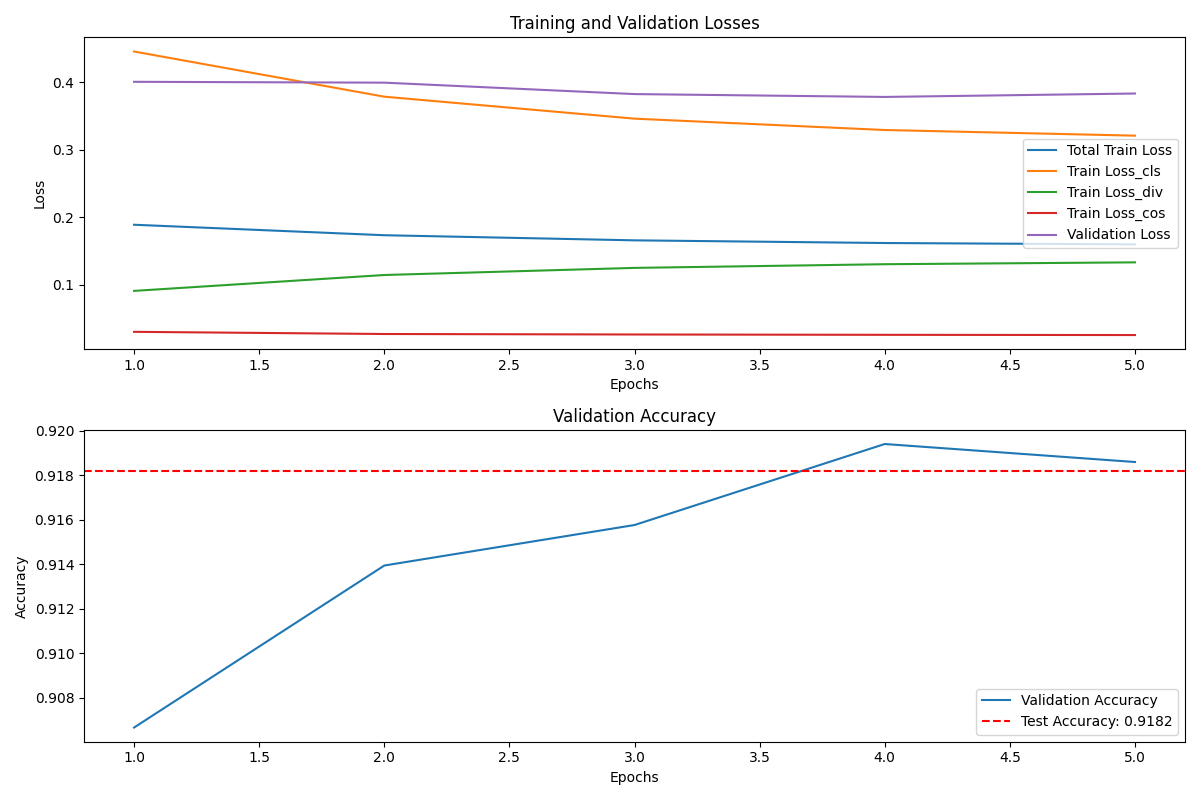

# Task 3. LoRA (Low-Rank Adaptation) ✅

Implement LoRA to train the 12-layer student model. (1 point) ✅

Due to Puffer issues with Triton and NVIDIA Library compatibility issues with Python 3.12, the below cells were run on Google Colab!

In [1]:
!pip install transformers datasets evaluate peft matplotlib seaborn scikit-learn tqdm
!pip install -q bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Import Libraries and Set Seeds

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import evaluate
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    default_data_collator,
    get_scheduler
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    PeftModel,
    PeftConfig
)

# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Define Utility Functions

In [3]:
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        # Due to the design of 4bit linear layers from bitsandbytes
        # one needs to multiply the number of parameters by 2 to get
        # the correct number of parameters
        if param.__class__.__name__ == "Params4bit":
            num_params = num_params * 2

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params

    print(f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.2f}%")
    return trainable_params, all_param

def compute_metrics(eval_pred):
    """Compute evaluation metrics (accuracy)."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).astype(np.float32).mean().item()}

## 4. Load and Preprocess the Dataset

We'll load the Jigsaw Toxic Comment Classification dataset (Civil Comments) and preprocess it for training.

In [4]:
def load_toxic_comments_dataset(model_name_or_path="bert-base-uncased", max_length=128, batch_size=32):
    """
    Load the Jigsaw Toxic Comment Classification dataset and preprocess it.

    Args:
        model_name_or_path (str): The model name or path for the tokenizer
        max_length (int): Maximum sequence length
        batch_size (int): Batch size for data loaders

    Returns:
        tokenizer: The tokenizer used for preprocessing
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        test_dataloader: DataLoader for test data
        num_labels: Number of labels in the dataset
    """
    print("Loading Jigsaw Toxic Comment Classification dataset...")

    # Load the Civil Comments dataset (contains toxic comments)
    from datasets import load_dataset
    dataset = load_dataset("civil_comments")

    # Extract the relevant columns (text and toxicity label)
    dataset = dataset.map(
        lambda example: {
            "text": example["text"],
            "label": 1 if example["toxicity"] > 0.5 else 0
        }
    )

    # Create a balanced dataset (50% toxic, 50% non-toxic)
    toxic_comments = dataset["train"].filter(lambda example: example["label"] == 1)
    non_toxic_comments = dataset["train"].filter(lambda example: example["label"] == 0)

    # Sample to ensure balance
    max_samples = min(len(toxic_comments), len(non_toxic_comments), 25000)  # Limit to 25k per class for efficiency
    toxic_samples = toxic_comments.select(range(max_samples))
    non_toxic_samples = non_toxic_comments.select(range(max_samples))

    # Combine and shuffle
    from datasets import concatenate_datasets
    balanced_dataset = concatenate_datasets([toxic_samples, non_toxic_samples])
    balanced_dataset = balanced_dataset.shuffle(seed=SEED)

    # Split into train, validation, and test sets (80%, 10%, 10%)
    train_val_dataset, test_dataset = balanced_dataset.train_test_split(test_size=0.1, seed=SEED).values()
    train_dataset, val_dataset = train_val_dataset.train_test_split(test_size=0.11, seed=SEED).values()  # 0.11 of 90% is ~10% of total

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    # Tokenize datasets
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

    print("Tokenizing datasets...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    # Format datasets for PyTorch - remove all columns except those needed by the model
    columns_to_keep = ['input_ids', 'attention_mask', 'label']
    tokenized_train = tokenized_train.remove_columns([col for col in tokenized_train.column_names if col not in columns_to_keep])
    tokenized_val = tokenized_val.remove_columns([col for col in tokenized_val.column_names if col not in columns_to_keep])
    tokenized_test = tokenized_test.remove_columns([col for col in tokenized_test.column_names if col not in columns_to_keep])

    # Rename 'label' to 'labels' to match model expectations
    tokenized_train = tokenized_train.rename_column('label', 'labels')
    tokenized_val = tokenized_val.rename_column('label', 'labels')
    tokenized_test = tokenized_test.rename_column('label', 'labels')

    tokenized_train.set_format("torch")
    tokenized_val.set_format("torch")
    tokenized_test.set_format("torch")

    # Create data loaders
    from torch.utils.data import DataLoader
    from transformers import DataCollatorWithPadding

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    train_dataloader = DataLoader(
        tokenized_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        tokenized_val, batch_size=batch_size, collate_fn=data_collator
    )
    test_dataloader = DataLoader(
        tokenized_test, batch_size=batch_size, collate_fn=data_collator
    )

    # Number of labels (binary classification - toxic or not)
    num_labels = 2

    return tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, tokenized_train, tokenized_val, tokenized_test

# Load the dataset
tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, train_dataset, val_dataset, test_dataset = load_toxic_comments_dataset(
    model_name_or_path="bert-base-uncased",
    max_length=128,
    batch_size=32
)

Loading Jigsaw Toxic Comment Classification dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Train dataset size: 40050
Validation dataset size: 4950
Test dataset size: 5000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/40050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## 5. Set Up LoRA Configuration and Train the Model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-d5fb47f9361e>:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Base model loaded: bert-base-uncased
Base model parameters: 109,483,778
trainable params: 443,906 || all params: 109,927,684 || trainable%: 0.4038
trainable params: 443,906 || all params: 109,927,684 || trainable%: 0.40%
Training with LoRA...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.293100,0.244775,0.906465
2,0.213800,0.264774,0.902828
3,0.188000,0.220778,0.914545
4,0.140300,0.246183,0.913737
5,0.111000,0.264603,0.913333


Evaluating LoRA model on test set...


Test accuracy: 0.9206


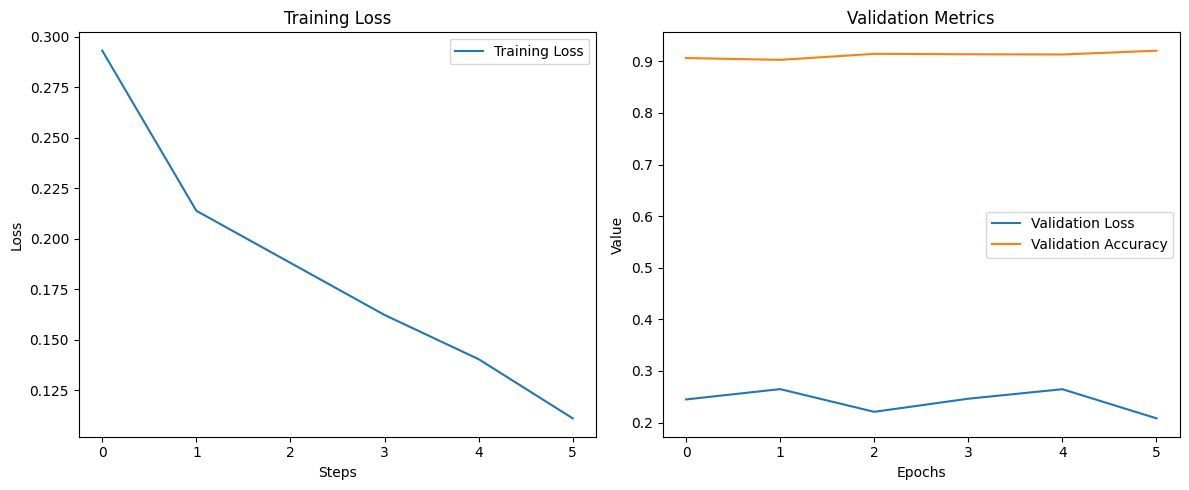

Results saved to lora_model/results.txt


In [6]:
def train_and_evaluate_lora(
    model_name="bert-base-uncased",
    num_epochs=5,
    learning_rate=1e-3,
    weight_decay=0.01,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    output_dir="lora_model"
):
    """
    Train and evaluate a model using LoRA (Low-Rank Adaptation).
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load base model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

    print(f"Base model loaded: {model_name}")
    base_params = count_parameters(model)
    print(f"Base model parameters: {base_params:,}")

    # Define LoRA Configuration
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        # Target the attention modules in BERT
        target_modules=["query", "key", "value"],
    )

    # Apply LoRA to model
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    trainable_params, all_params = print_trainable_parameters(model)

    # Using Huggingface Trainer for training
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="none",  # Disable wandb, tensorboard etc.
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
        compute_metrics=compute_metrics,
    )

    # Train the model
    print("Training with LoRA...")
    trainer.train()

    # Evaluate the model
    print("Evaluating LoRA model on test set...")
    eval_results = trainer.evaluate(test_dataset)
    print(f"Test accuracy: {eval_results['eval_accuracy']:.4f}")

    # Save the model
    trainer.save_model(os.path.join(output_dir, "best_model"))

    # Save the results
    test_results = {
        'test_loss': eval_results['eval_loss'],
        'test_accuracy': eval_results['eval_accuracy'],
        'trainable_params': trainable_params,
        'all_params': all_params,
        'trainable_percentage': 100 * trainable_params / all_params
    }

    # Get training logs
    train_logs = trainer.state.log_history

    # Extract training and validation metrics
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for log in train_logs:
        if 'loss' in log and 'eval_loss' not in log:
            train_losses.append(log['loss'])
        if 'eval_loss' in log:
            eval_losses.append(log['eval_loss'])
            eval_accuracies.append(log['eval_accuracy'])

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(eval_losses, label='Validation Loss')
    plt.plot(eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Validation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'))
    plt.show()

    # Save the results to a file
    with open(os.path.join(output_dir, 'results.txt'), 'w') as f:
        f.write(f"Model: LoRA fine-tuned {model_name}\n")
        f.write(f"LoRA rank (r): {lora_r}\n")
        f.write(f"LoRA alpha: {lora_alpha}\n")
        f.write(f"LoRA dropout: {lora_dropout}\n")
        f.write(f"Learning rate: {learning_rate}\n")
        f.write(f"Number of epochs: {num_epochs}\n")
        f.write(f"Base parameters: {all_params:,}\n")
        f.write(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / all_params:.2f}%)\n")
        f.write(f"Test loss: {test_results['test_loss']}\n")
        f.write(f"Test accuracy: {test_results['test_accuracy']}\n")

    print(f"Results saved to {output_dir}/results.txt")
    return model, test_results

# Train and evaluate the LoRA model
model, test_results = train_and_evaluate_lora(
    model_name="bert-base-uncased",
    num_epochs=5,
    learning_rate=1e-3,
    weight_decay=0.01,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    output_dir="lora_model"
)

## 6. Test the Model with Sample Inputs

In [7]:
def predict_toxicity(text, model, tokenizer, threshold=0.5):
    """
    Predict whether a text is toxic.

    Args:
        text: Input text
        model: The model to use for prediction
        tokenizer: The tokenizer
        threshold: Probability threshold for classification

    Returns:
        prediction: Dictionary containing prediction results
    """
    # Tokenize input text
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Get prediction
    toxic_prob = probabilities[0, 1].item()
    is_toxic = toxic_prob >= threshold

    prediction = {
        "text": text,
        "is_toxic": bool(is_toxic),
        "toxic_probability": toxic_prob,
        "non_toxic_probability": probabilities[0, 0].item()
    }

    return prediction

# Test the model with sample comments
sample_texts = [
    "This is a great movie, I really enjoyed it!",
    "You are such an idiot, I can't believe how stupid you are.",
    "The service at this restaurant was excellent.",
    "This article is very informative and well-written.",
    "I hate this product, it's complete garbage."
]

for text in sample_texts:
    prediction = predict_toxicity(text, model, tokenizer)
    print("-" * 80)
    print(f"Text: {prediction['text']}")
    print(f"Prediction: {'TOXIC' if prediction['is_toxic'] else 'NOT TOXIC'}")
    print(f"Toxic probability: {prediction['toxic_probability']:.4f}")
    print(f"Non-toxic probability: {prediction['non_toxic_probability']:.4f}")

--------------------------------------------------------------------------------
Text: This is a great movie, I really enjoyed it!
Prediction: NOT TOXIC
Toxic probability: 0.0010
Non-toxic probability: 0.9990
--------------------------------------------------------------------------------
Text: You are such an idiot, I can't believe how stupid you are.
Prediction: TOXIC
Toxic probability: 0.9982
Non-toxic probability: 0.0018
--------------------------------------------------------------------------------
Text: The service at this restaurant was excellent.
Prediction: NOT TOXIC
Toxic probability: 0.0012
Non-toxic probability: 0.9988
--------------------------------------------------------------------------------
Text: This article is very informative and well-written.
Prediction: NOT TOXIC
Toxic probability: 0.0009
Non-toxic probability: 0.9991
--------------------------------------------------------------------------------
Text: I hate this product, it's complete garbage.
Prediction: T

## 7. Save the Model for Later Use

The model has already been saved to the `lora_model/best_model` directory

# Task 4. Evaluation and Analysis ✅

1) Evaluate the models on the test set, and analyze the performance of the models trained with Odd Layers, Even Layers, and LoRA. Discuss the differences in performance across the three methods. (0.5 point) ✅
2) Discuss the challenges encountered during the implementation, specifically comparing distillation fine-tuning models (Odd and Even Layer) with LoRA fine-tuning. ✅
3) Propose improvements or modifications to address the challenges. (0.5 point) ✅

### 1. Install Libraries

In [2]:
!pip install -q transformers datasets evaluate peft pandas matplotlib seaborn scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 2. Import Libraries

In [3]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 3. Define Data Loader Function

In [4]:
def load_toxic_comments_dataset(model_name_or_path="bert-base-uncased", max_length=128, batch_size=32):
    """
    Load the Jigsaw Toxic Comment Classification dataset and preprocess it.

    Args:
        model_name_or_path (str): The model name or path for the tokenizer
        max_length (int): Maximum sequence length
        batch_size (int): Batch size for data loaders

    Returns:
        tokenizer: The tokenizer used for preprocessing
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        test_dataloader: DataLoader for test data
        num_labels: Number of labels in the dataset
    """
    print("Loading Jigsaw Toxic Comment Classification dataset...")

    # Load the Civil Comments dataset (contains toxic comments)
    from datasets import load_dataset
    dataset = load_dataset("civil_comments")

    # Extract the relevant columns (text and toxicity label)
    dataset = dataset.map(
        lambda example: {
            "text": example["text"],
            "label": 1 if example["toxicity"] > 0.5 else 0
        }
    )

    # Create a balanced dataset (50% toxic, 50% non-toxic)
    toxic_comments = dataset["train"].filter(lambda example: example["label"] == 1)
    non_toxic_comments = dataset["train"].filter(lambda example: example["label"] == 0)

    # Sample to ensure balance
    max_samples = min(len(toxic_comments), len(non_toxic_comments), 25000)  # Limit to 25k per class for efficiency
    toxic_samples = toxic_comments.select(range(max_samples))
    non_toxic_samples = non_toxic_comments.select(range(max_samples))

    # Combine and shuffle
    from datasets import concatenate_datasets
    balanced_dataset = concatenate_datasets([toxic_samples, non_toxic_samples])
    balanced_dataset = balanced_dataset.shuffle(seed=SEED)

    # Split into train, validation, and test sets (80%, 10%, 10%)
    train_val_dataset, test_dataset = balanced_dataset.train_test_split(test_size=0.1, seed=SEED).values()
    train_dataset, val_dataset = train_val_dataset.train_test_split(test_size=0.11, seed=SEED).values()  # 0.11 of 90% is ~10% of total

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    # Tokenize datasets
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

    print("Tokenizing datasets...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    # Format datasets for PyTorch - remove all columns except those needed by the model
    columns_to_keep = ['input_ids', 'attention_mask', 'label']
    tokenized_train = tokenized_train.remove_columns([col for col in tokenized_train.column_names if col not in columns_to_keep])
    tokenized_val = tokenized_val.remove_columns([col for col in tokenized_val.column_names if col not in columns_to_keep])
    tokenized_test = tokenized_test.remove_columns([col for col in tokenized_test.column_names if col not in columns_to_keep])

    # Rename 'label' to 'labels' to match model expectations
    tokenized_train = tokenized_train.rename_column('label', 'labels')
    tokenized_val = tokenized_val.rename_column('label', 'labels')
    tokenized_test = tokenized_test.rename_column('label', 'labels')

    tokenized_train.set_format("torch")
    tokenized_val.set_format("torch")
    tokenized_test.set_format("torch")

    # Create data loaders
    from torch.utils.data import DataLoader
    from transformers import DataCollatorWithPadding

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    train_dataloader = DataLoader(
        tokenized_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        tokenized_val, batch_size=batch_size, collate_fn=data_collator
    )
    test_dataloader = DataLoader(
        tokenized_test, batch_size=batch_size, collate_fn=data_collator
    )

    # Number of labels (binary classification - toxic or not)
    num_labels = 2

    return tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, tokenized_train, tokenized_val, tokenized_test

### 4. Load the Test Dataset

In [5]:
print("Loading test data...")
tokenizer, _, _, test_dataloader, _, _, _, _ = load_toxic_comments_dataset(
    model_name_or_path="bert-base-uncased",
    max_length=128,
    batch_size=32
)

Loading test data...
Loading Jigsaw Toxic Comment Classification dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Train dataset size: 40050
Validation dataset size: 4950
Test dataset size: 5000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/40050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Toxic Comment Classification: Model Evaluation (Part 2)

## Part 2: Model Loading and Evaluation Functions

In this part, we'll define functions to load the trained models and evaluate them on the test set.

In [6]:
os.chdir("/content/drive/MyDrive/NLPA7")

### 1. Model Loading Functions

In [7]:
def load_model_and_results(model_path, model_type="distillation"):
    """
    Load a trained model and its results.

    Args:
        model_path: Path to the model directory
        model_type: Type of the model ("distillation" or "lora")

    Returns:
        model: The loaded model
        tokenizer: The tokenizer
        results: Dictionary containing test results
    """
    # Load results
    with open(os.path.join(model_path, 'results.txt'), 'r') as f:
        results_text = f.read()

    # Parse results
    results = {}

    # Extract test loss
    test_loss_line = [line for line in results_text.split('\n') if 'Test loss:' in line][0]
    results['test_loss'] = float(test_loss_line.split(': ')[1])

    # Extract test accuracy
    test_acc_line = [line for line in results_text.split('\n') if 'Test accuracy:' in line][0]
    results['test_accuracy'] = float(test_acc_line.split(': ')[1])

    # Load model and tokenizer
    model_path = os.path.join(model_path, "best_model")

    if model_type == "distillation":
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
    elif model_type == "lora":
        config = PeftConfig.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
        model = PeftModel.from_pretrained(model, model_path)

    return model, tokenizer, results

### 2. Model Evaluation Function

In [8]:
def evaluate_model_on_test_set(model, tokenizer, test_dataloader):
    """
    Evaluate a model on the test set.

    Args:
        model: The model to evaluate
        tokenizer: The tokenizer
        test_dataloader: DataLoader for test data

    Returns:
        Dictionary containing evaluation metrics
    """
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    confusion = confusion_matrix(all_labels, all_predictions)

    metrics = {
        'test_loss': total_loss / len(test_dataloader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': confusion
    }

    return metrics

### 3. Prepare for Model Evaluation

Before evaluating your models, you need to upload your trained model folders to Colab. You should have the following folders:
- odd_layer_model
- even_layer_model
- lora_model

Use the code cell below to upload your model folders. Each folder should contain a 'best_model' subdirectory and a 'results.txt' file.

In [15]:
# Create directories for the models
!mkdir -p odd_layer_model
!mkdir -p even_layer_model
!mkdir -p lora_model


!unzip -q -o "odd_layer_model.zip"
!unzip -q -o "even_layer_model.zip"
!unzip -q -o "lora_model.zip"

# Toxic Comment Classification: Model Evaluation (Part 3)

## Part 3: Model Comparison and Results Visualization

In this part, we'll evaluate all models, compare their performance, and generate visualizations and reports.

### 1. Function to Save Comparative Results

In [9]:
def save_comparative_results(results_dict, output_dir="comparison_results"):
    """
    Save comparative results of all models.

    Args:
        results_dict: Dictionary containing results for all models
        output_dir: Directory to save results
    """
    os.makedirs(output_dir, exist_ok=True)

    # Create a comparison table
    comparison_data = []
    for model_name, metrics in results_dict.items():
        row = {
            'Model Type': model_name,
            'Test Loss': metrics['test_loss'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1_score']
        }
        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)

    # Save as CSV
    df.to_csv(os.path.join(output_dir, 'comparison_results.csv'), index=False)

    # Display as DataFrame
    display(df)

    # Plot metrics comparison
    plt.figure(figsize=(12, 8))

    # Metrics bar chart
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    ax = plt.subplot(2, 1, 1)
    df_plot = df.melt(id_vars=['Model Type'], value_vars=metrics_to_plot, var_name='Metric', value_name='Value')
    sns.barplot(x='Model Type', y='Value', hue='Metric', data=df_plot, ax=ax)
    plt.title('Performance Metrics Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)

    # Loss comparison
    ax = plt.subplot(2, 1, 2)
    sns.barplot(x='Model Type', y='Test Loss', data=df, ax=ax)
    plt.title('Test Loss Comparison')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'metrics_comparison.png'))
    plt.show()

    # Plot confusion matrices
    plt.figure(figsize=(15, 5))
    for i, (model_name, metrics) in enumerate(results_dict.items()):
        plt.subplot(1, 3, i+1)
        confusion = metrics['confusion_matrix']
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Non-Toxic', 'Toxic'],
                   yticklabels=['Non-Toxic', 'Toxic'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrices.png'))
    plt.show()

    # Create analysis report
    analysis_report = "# Model Comparison Analysis Report\n\n"

    analysis_report += "## Performance Comparison\n\n"

    # Find the best model for each metric
    best_model = {
        'Accuracy': df.loc[df['Accuracy'].idxmax()]['Model Type'],
        'Precision': df.loc[df['Precision'].idxmax()]['Model Type'],
        'Recall': df.loc[df['Recall'].idxmax()]['Model Type'],
        'F1 Score': df.loc[df['F1 Score'].idxmax()]['Model Type'],
        'Loss': df.loc[df['Test Loss'].idxmin()]['Model Type']
    }

    analysis_report += "## Best Performing Models\n\n"
    analysis_report += f"- **Best Accuracy**: {best_model['Accuracy']} ({df['Accuracy'].max():.4f})\n"
    analysis_report += f"- **Best Precision**: {best_model['Precision']} ({df['Precision'].max():.4f})\n"
    analysis_report += f"- **Best Recall**: {best_model['Recall']} ({df['Recall'].max():.4f})\n"
    analysis_report += f"- **Best F1 Score**: {best_model['F1 Score']} ({df['F1 Score'].max():.4f})\n"
    analysis_report += f"- **Lowest Loss**: {best_model['Loss']} ({df['Test Loss'].min():.4f})\n\n"

    analysis_report += "## Analysis of Differences\n\n"
    analysis_report += "### Odd vs Even Layer Distillation\n\n"

    odd_metrics = df[df['Model Type'] == 'Odd Layer Distillation'].iloc[0]
    even_metrics = df[df['Model Type'] == 'Even Layer Distillation'].iloc[0]

    acc_diff = odd_metrics['Accuracy'] - even_metrics['Accuracy']
    f1_diff = odd_metrics['F1 Score'] - even_metrics['F1 Score']

    if acc_diff > 0:
        analysis_report += f"Odd layer distillation outperforms even layer distillation in terms of accuracy by {abs(acc_diff):.4f}. "
    else:
        analysis_report += f"Even layer distillation outperforms odd layer distillation in terms of accuracy by {abs(acc_diff):.4f}. "

    if f1_diff > 0:
        analysis_report += f"Similarly, odd layer distillation has a higher F1 score by {abs(f1_diff):.4f}.\n\n"
    else:
        analysis_report += f"However, even layer distillation has a higher F1 score by {abs(f1_diff):.4f}.\n\n"

    analysis_report += "This suggests that "
    if acc_diff > 0:
        analysis_report += "the odd-numbered layers in BERT contain more task-relevant information for toxic comment classification. "
        analysis_report += "These layers might capture more semantic understanding needed for this task.\n\n"
    else:
        analysis_report += "the even-numbered layers in BERT contain more task-relevant information for toxic comment classification. "
        analysis_report += "These layers might capture more semantic understanding needed for this task.\n\n"

    analysis_report += "### Distillation vs LoRA\n\n"

    best_distil = odd_metrics if odd_metrics['Accuracy'] > even_metrics['Accuracy'] else even_metrics
    best_distil_name = 'Odd Layer Distillation' if odd_metrics['Accuracy'] > even_metrics['Accuracy'] else 'Even Layer Distillation'
    lora_metrics = df[df['Model Type'] == 'LoRA'].iloc[0]

    acc_diff = best_distil['Accuracy'] - lora_metrics['Accuracy']
    f1_diff = best_distil['F1 Score'] - lora_metrics['F1 Score']

    if acc_diff > 0:
        analysis_report += f"The best distillation approach ({best_distil_name}) outperforms LoRA in terms of accuracy by {abs(acc_diff):.4f}. "
    else:
        analysis_report += f"LoRA outperforms the best distillation approach ({best_distil_name}) in terms of accuracy by {abs(acc_diff):.4f}. "

    if f1_diff > 0:
        analysis_report += f"Similarly, {best_distil_name} has a higher F1 score by {abs(f1_diff):.4f}.\n\n"
    else:
        analysis_report += f"Similarly, LoRA has a higher F1 score by {abs(f1_diff):.4f}.\n\n"

    # Save analysis report
    with open(os.path.join(output_dir, 'analysis_report.md'), 'w') as f:
        f.write(analysis_report)

    # Display the analysis report
    from IPython.display import Markdown
    display(Markdown(analysis_report))

    print(f"\nResults saved to {output_dir}/")
    return df

### 2. Evaluate All Models and Compare Results

In [10]:
# Define model directories
model_dirs = {
    'Odd Layer Distillation': 'odd_layer_model',
    'Even Layer Distillation': 'even_layer_model',
    'LoRA': 'lora_model'
}

# Load models and results
results = {}

for model_name, model_dir in model_dirs.items():
    print(f"Evaluating {model_name}...")

    model_type = "lora" if model_name == "LoRA" else "distillation"
    model, tokenizer, model_results = load_model_and_results(model_dir, model_type)

    # Evaluate on test set
    metrics = evaluate_model_on_test_set(model, tokenizer, test_dataloader)

    # Store results
    results[model_name] = metrics

    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")

Evaluating Odd Layer Distillation...
  Accuracy: 0.9182
  F1 Score: 0.9198
Evaluating Even Layer Distillation...
  Accuracy: 0.9208
  F1 Score: 0.9215
Evaluating LoRA...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Accuracy: 0.9206
  F1 Score: 0.9217


### 3. Save and Visualize Comparative Results

,Model Type,Test Loss,Accuracy,Precision,Recall,F1 Score
0,Odd Layer Distillation,0.386519,0.9182,0.909302,0.930583,0.919820
1,Even Layer Distillation,0.376649,0.9208,0.920792,0.922253,0.921522
2,LoRA,0.208794,0.9206,0.916471,0.927013,0.921712


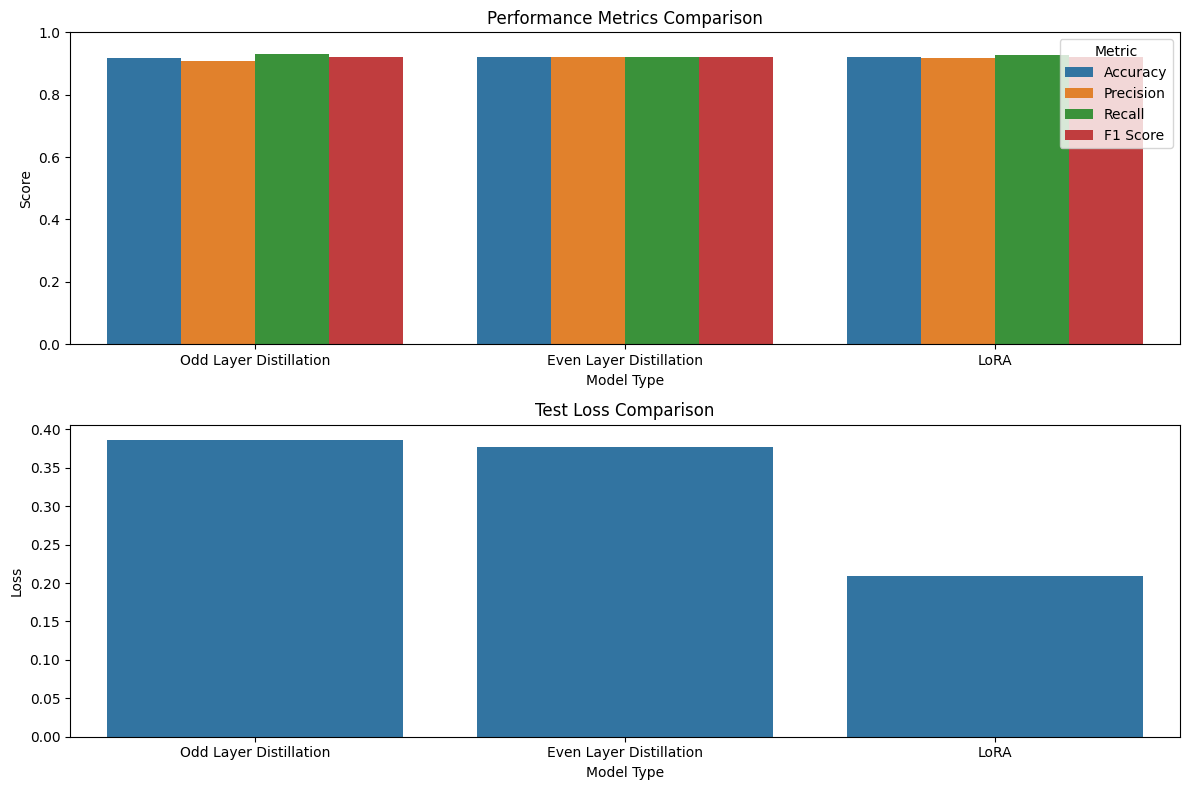

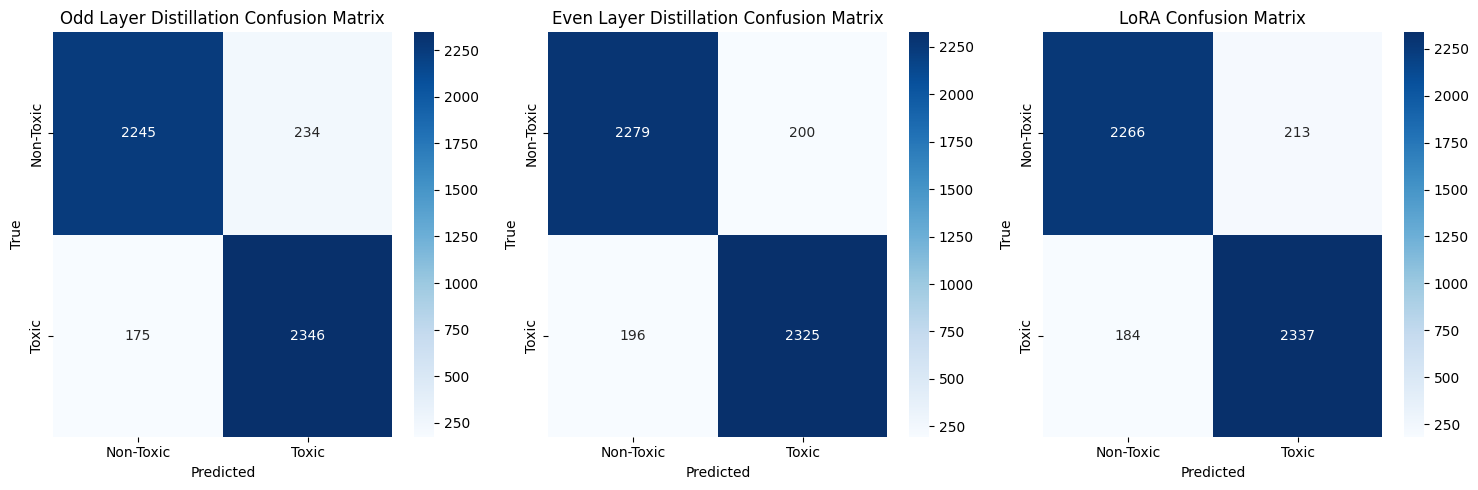

# Model Comparison Analysis Report

## Performance Comparison

## Best Performing Models

- **Best Accuracy**: Even Layer Distillation (0.9208)
- **Best Precision**: Even Layer Distillation (0.9208)
- **Best Recall**: Odd Layer Distillation (0.9306)
- **Best F1 Score**: LoRA (0.9217)
- **Lowest Loss**: LoRA (0.2088)

## Analysis of Differences

### Odd vs Even Layer Distillation

Even layer distillation outperforms odd layer distillation in terms of accuracy by 0.0026. However, even layer distillation has a higher F1 score by 0.0017.

This suggests that the even-numbered layers in BERT contain more task-relevant information for toxic comment classification. These layers might capture more semantic understanding needed for this task.

### Distillation vs LoRA

The best distillation approach (Even Layer Distillation) outperforms LoRA in terms of accuracy by 0.0002. Similarly, LoRA has a higher F1 score by 0.0002.




Results saved to comparison_results/


In [11]:
# Save comparative results
df = save_comparative_results(results)

# Task 5. Web Application ✅

Develop a simple web application that classifies whether a given text input is toxic or hate speech. (1 point) ✅

The web application should:
1) Include an input box where users can type in a text prompt. ✅
2) Based on the input, the model should classify and display whether the text is toxic or not. For example, if the input is ”I hate you”, the model might classify it as toxic. ✅

Here's the app script, more detailed webapp implmentation on the GitHub Repository: https://github.com/aryashah2k/NLP-NLU


# `toxic_comment_classifier`

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Toxic Comment Classifier

A standalone script that uses a pre-trained Hugging Face model to classify text as toxic or non-toxic and visualize the results.
"""

import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Default model to use (replace with your model)
DEFAULT_MODEL = "distilbert-base-uncased-finetuned-sst-2-english"

class ToxicClassifier:
    def __init__(self, model_name_or_path):
        """Initialize the classifier with a pre-trained model."""
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        try:
            print(f"Loading model: {model_name_or_path}")
            
            # Load model
            self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
            
            self.model = self.model.to(self.device)
            self.model.eval()
            print("Model loaded successfully!")
            
            # Set labels based on the model
            if hasattr(self.model.config, 'id2label'):
                self.id2label = self.model.config.id2label
            else:
                # Default for binary toxicity classification
                self.id2label = {0: "Non-Toxic", 1: "Toxic"}
            
            print(f"Label mapping: {self.id2label}")
            
        except Exception as e:
            print(f"Error loading model: {e}")
            sys.exit(1)
    
    def classify(self, text, max_length=128):
        """Classify a text as toxic or non-toxic."""
        # Tokenize input
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            padding=True, 
            max_length=max_length
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Get prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        prediction = torch.argmax(logits, dim=-1).item()
        
        # Get label name
        label = self.id2label[prediction]
        
        # Return classification results
        result = {
            'text': text,
            'prediction': prediction,
            'label': label,
            'probabilities': probabilities.cpu().numpy()[0],
            'confidence': probabilities.cpu().numpy()[0][prediction],
            'id2label': self.id2label
        }
        
        return result
    
    def batch_classify(self, texts, max_length=128):
        """Classify multiple texts."""
        results = []
        for text in texts:
            result = self.classify(text, max_length)
            results.append(result)
        
        return results

def visualize_result(result, display=True, save_path=None):
    """
    Visualize classification result with a color-coded confidence bar.
    
    Args:
        result: Classification result dictionary
        display: Whether to display the plot
        save_path: Path to save the visualization image
    """
    # Create color gradient from green (non-toxic) to red (toxic)
    cmap = LinearSegmentedColormap.from_list('toxicity', ['green', 'yellow', 'red'])
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})
    
    # Plot text and result
    truncated_text = result['text'][:100] + "..." if len(result['text']) > 100 else result['text']
    ax1.text(0.5, 0.5, f"Text: {truncated_text}\n\nClassification: {result['label']}\nConfidence: {result['confidence']:.2%}", 
             horizontalalignment='center', verticalalignment='center', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))
    ax1.set_axis_off()
    
    # Plot probability bars
    labels = list(result['id2label'].values())
    probs = result['probabilities']
    colors = [cmap(p) if i == 1 else cmap(1-p) for i, p in enumerate(probs)]
    
    ax2.barh(labels, probs, color=colors)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Probability')
    ax2.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Annotate bars with percentage
    for i, p in enumerate(probs):
        ax2.text(max(p + 0.01, 0.1), i, f"{p:.2%}", va='center')
    
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to: {save_path}")
    
    # Display if requested
    if display:
        plt.show()
    
    return fig

def visualize_batch_results(results, display=True, save_path=None):
    """
    Visualize batch classification results with a comparison chart.
    
    Args:
        results: List of classification result dictionaries
        display: Whether to display the plot
        save_path: Path to save the visualization image
    """
    # Create color gradient
    cmap = LinearSegmentedColormap.from_list('toxicity', ['green', 'yellow', 'red'])
    
    # Prepare data
    texts = [r['text'][:50] + "..." if len(r['text']) > 50 else r['text'] for r in results]
    toxic_probs = [r['probabilities'][1] for r in results]
    labels = [r['label'] for r in results]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, max(6, len(results) * 0.5)))
    
    # Plot bars
    y_pos = np.arange(len(texts))
    bars = ax.barh(y_pos, toxic_probs, color=[cmap(p) for p in toxic_probs])
    
    # Add labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(texts)
    ax.set_xlabel('Toxicity Probability')
    ax.set_title('Toxicity Classification Comparison')
    ax.set_xlim(0, 1)
    
    # Add threshold line
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
    
    # Add annotations
    for i, bar in enumerate(bars):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f"{toxic_probs[i]:.2%} - {labels[i]}", va='center')
    
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to: {save_path}")
    
    # Display if requested
    if display:
        plt.show()
    
    return fig

def interactive_mode(classifier):
    """Run an interactive classification session."""
    print("\n===== Toxic Comment Classifier =====")
    print("Enter comments to classify (or 'quit' to exit).")
    
    while True:
        text = input("\nEnter text: ")
        if text.lower() == 'quit':
            break
        
        result = classifier.classify(text)
        
        print(f"\nClassification: {result['label']}")
        print(f"Confidence: {result['confidence']:.2%}")
        
        # Visualize
        visualize_result(result)

def main():
    parser = argparse.ArgumentParser(description="Toxic Comment Classifier")
    parser.add_argument("--model", type=str, default=DEFAULT_MODEL, 
                        help=f"Model ID or path (default: {DEFAULT_MODEL})")
    
    # Input methods
    parser.add_argument("--text", type=str, help="Text to classify")
    parser.add_argument("--file", type=str, help="File with texts (one per line)")
    parser.add_argument("--interactive", action="store_true", help="Interactive mode")
    
    # Output options
    parser.add_argument("--output", type=str, help="Output file for visualization")
    parser.add_argument("--no-display", action="store_true", help="Don't display visualization")
    
    args = parser.parse_args()
    
    # Create classifier
    classifier = ToxicClassifier(
        model_name_or_path=args.model
    )
    
    # Handle input mode
    if args.interactive:
        interactive_mode(classifier)
    elif args.file:
        try:
            with open(args.file, 'r', encoding='utf-8') as f:
                texts = [line.strip() for line in f if line.strip()]
            
            results = classifier.batch_classify(texts)
            
            # Print results
            print("\n----- Classification Results -----")
            for i, result in enumerate(results):
                print(f"{i+1}. Text: {result['text'][:50]}...")
                print(f"   Classification: {result['label']} (Confidence: {result['confidence']:.2%})")
            
            # Visualize
            visualize_batch_results(
                results, 
                display=not args.no_display,
                save_path=args.output or 'batch_results.png'
            )
            
        except Exception as e:
            print(f"Error processing file: {e}")
    elif args.text:
        result = classifier.classify(args.text)
        
        # Print result
        print("\n----- Classification Result -----")
        print(f"Text: {result['text']}")
        print(f"Classification: {result['label']} (Confidence: {result['confidence']:.2%})")
        
        # Visualize
        visualize_result(
            result, 
            display=not args.no_display,
            save_path=args.output or 'classification_result.png'
        )
    else:
        # Default to interactive mode
        interactive_mode(classifier)

if __name__ == "__main__":
    main()


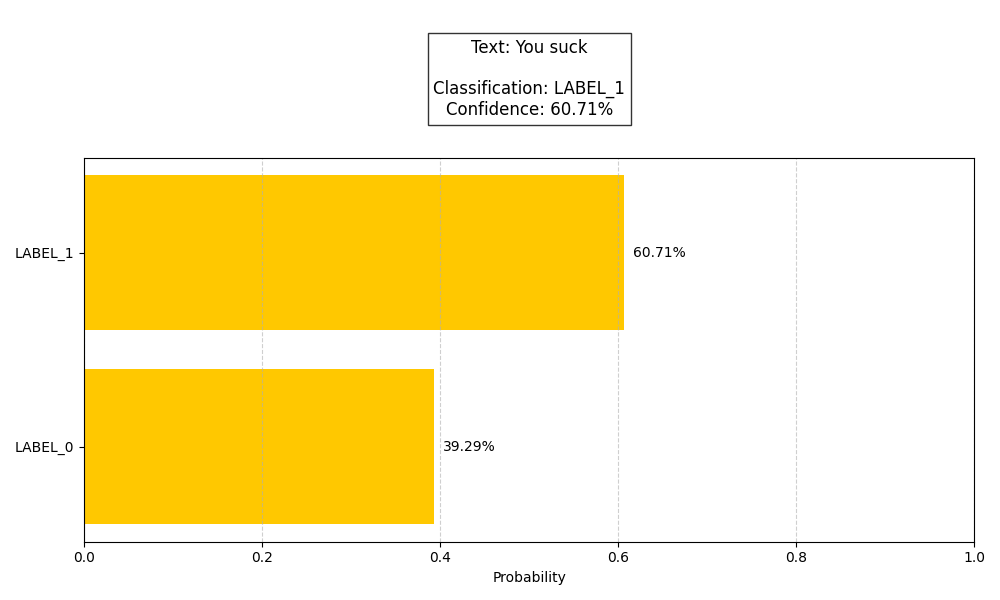

# Thank You! 🤗